# Getting Started With Robot Inverse Kinematics (IK)

Welcome to the first guide in the series of getting started with Dr.QP robot Inverse Kinematics (IK).
In this guide, we will cover the basics of IK and how to use it to control a robot.

## What is Inverse Kinematics?
Inverse Kinematics (IK) is a technique used in robotics to determine the joint angles required to achieve a desired end-effector position. It is the process of solving the inverse problem of forward kinematics, which calculates the end-effector position given the joint angles.

## Why is Inverse Kinematics Important?
Inverse Kinematics is important because it allows robots to perform complex movements and tasks. By calculating the joint angles required to reach a specific position, robots can navigate their environment and interact with objects more effectively.

## How to Use Inverse Kinematics
To use Inverse Kinematics, you need to have a model of your robot's kinematics. This model includes the lengths of the robot's links and the joint angles. Once you have this model, you can use it to calculate the joint angles required to achieve a desired end-effector position.

## Setting up the Jupyter notebook

Before we start, lets configure matplotlib to display plots inline:

In [1]:
%matplotlib inline

As well as enable live python modules reloading, so you can change the code in sibling files and see the results immediately without restarting the kernel

In [2]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

## The robot model

For this tutorial we will use the simplest part of Dr.QP robot - a single leg.

It has a 3 degrees of freedom and consists of 3 links:
 - coxa (hip)
 - femur (thigh)
 - tibia (shin)
 
and 3 joints:
 - alpha (coxa joint, hip joint)
 - beta (femur joint, thigh joint)
 - gamma (tibia joint, shin joint)

Links have only single property - length. They are connected to each other with joints. Joints have only single property - angle.

The diagrams below will make it much more clear, I promise.

The values below are the default parameters for the simulated leg used in this tutorial.

In [3]:
coxa_length = 5
femur_length = 8
tibia_length = 10

alpha = 0 # controls coxa angle, 0 is straight
beta = 0 # controls femur angle, 0 is straight
gamma = 0 # controls tibia angle, 0 is straight

## Forward kinematics

Before we dive into the details of how inverse kinematics works, let's first get familiar with forward kinematics. The forward kinematics of the robotic leg is the process of calculating the position of the foot based on the angles of the joints.

Coxa, femur and tibia are represented with vector that is rotated at its base. Each next link starts at the ened of the previous link.

In [4]:
from point import Point, Line

# unused
def forward_kinematics_rads(coxa_length, femur_length, tibia_length, alpha_rad, beta_rad, gamma_rad, start_z=2, body_length=3):
    start = Point(0, start_z)
    body = start + Point(body_length, 0, f'{alpha_rad=}rads')
    coxa = body + Point(coxa_length, 0, f'{beta_rad=}rads').rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0, f'{gamma_rad=}rads').rotate(beta_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(gamma_rad)

    return Line(start, body, 'Body'), Line(body, coxa, 'Coxa'), Line(coxa, femur, 'Femur'), Line(femur, tibia, 'Tibia')


Radians is a natural way to represent angles in most of the math related to robotics, however I find it easier to think in degrees, therefore I will be using degrees in this notebook.

In [5]:
import numpy as np

def forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_z=2, body_length=5):
    alpha_rad = np.radians(alpha)
    beta_rad = np.radians(beta) + alpha_rad
    gamma_rad = np.radians(gamma) + beta_rad

    start = Point(0, start_z)
    body = start + Point(body_length, 0, fr'$\alpha$={alpha}°')
    coxa = body + Point(coxa_length, 0, fr'$\beta$={beta}°').rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0, fr'$\gamma$={gamma}°').rotate(beta_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(gamma_rad)

    return Line(start, body, 'Body'), Line(body, coxa, 'Coxa'), Line(coxa, femur, 'Femur'), Line(femur, tibia, 'Tibia')


First, lets see how our leg looks in the neutral position. It is a straight line going from start point at (0, 0) and ending with the `Foot`

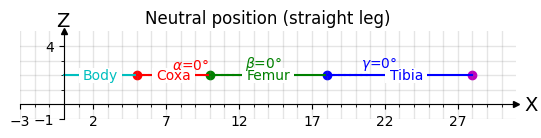

In [6]:
%matplotlib inline
from plotting import plot_leg_with_points

model = forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma)

_ = plot_leg_with_points(model, 'Neutral position (straight leg)')

Now lets try changing some angles to see how it behaves. Feel free to experiment with different values.

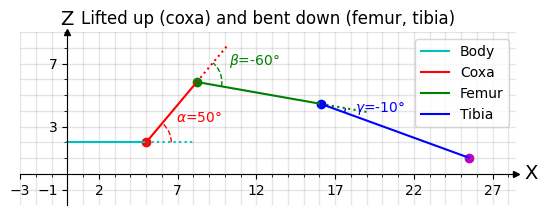

In [7]:
%matplotlib inline

model = forward_kinematics(coxa_length, femur_length, tibia_length, 50, -60, -10)

_ = plot_leg_with_points(model, 'Lifted up (coxa) and bent down (femur, tibia)', no_link_labels=True)


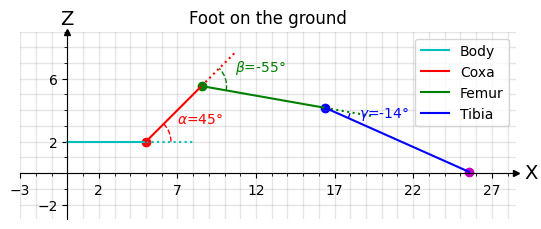

In [8]:
%matplotlib inline

# Lifted up (coxa) and bent down (femur), with foot on the ground (guessed angle)
model = forward_kinematics(coxa_length, femur_length, tibia_length, 45, -55, -14)

_ = plot_leg_with_points(model, 'Foot on the ground', no_link_labels=True)

## Exercise 1. Forward kinematics. Find angles at which the leg is on the ground

Its time to have a little fun with our robot.

Using the sliders on the interactive diagram below try to find angles at which the foot is on the ground.

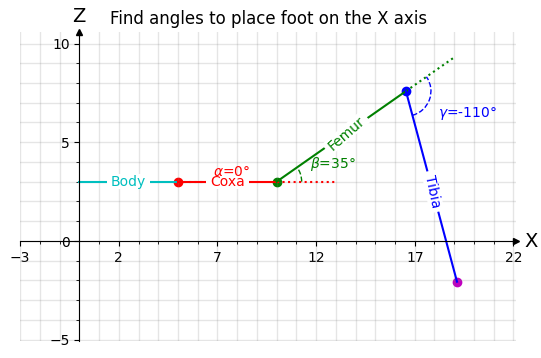

In [9]:

from plotting import plot_leg_update_lines
from ipywidgets import interact
import matplotlib


# To switch to interactive mode:
#  1. Set is_interactive to True
#  2. Restart kernel and run all the cells above
# DO NOT RUN THE CELLS BELOW, matplotlib's widget backend has to be the last magic executed to use interactive backend
is_interactive = False

matplotlib.use('widget' if is_interactive else 'inline')

start_z=3
alpha=0
beta=35
gamma=-110
model = forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_z=start_z)
fig, _, lines, joints = plot_leg_with_points(model, 'Find angles to place foot on the X axis', no_joint_labels=is_interactive, no_link_labels=is_interactive)

def update(alpha=alpha, beta=beta, gamma=gamma):
    model = forward_kinematics(coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_z=start_z)
    plot_leg_update_lines(model, lines, joints)
    fig.canvas.draw_idle()

if is_interactive:
    interact(update,
      alpha=(-180, 180, 0.1),
      beta=(-180, 180, 0.1),
      gamma=(-180, 180, 0.1))

In [10]:
if is_interactive:
    raise Exception("Stopping here to avoid breaking interactive mode. Set is_interactive to False in the cell above and execute it and all below.")

That was a fun little exercise, but it takes some effort to find just the right angle, and you might have noticed that there are more than one solution to it. 

The problem of having more than one solution is known as over-actuation. It happens for our robotic leg because there are 3 joints in the same plain, giving leg ability of reaching desired goal using various combinations of joint angles. Essentially if links create a polygon with more than 3 sides (more than triangle), then there are multiple solutions.

However, it is not an issue in the real Dr.QP hexapod robot as coxa joint is in the different plain in 3D space. Therefore we are not going to expand on this topic further right now and will keep coxa joint angle (alpha) fixed at 0 degree. This will prevent over-actuation and simplify the problem.

There are various ways to solve inverse kinematics problem. We are going to use the most basic one, which is based on trigonometry, since Dr.QP legs are not over-actuated.

## Solving inverse kinematics using trigonometry

Inverse kinematics is a process of finding angles of joints to reach a desired position, which will be the foot tip in our case.

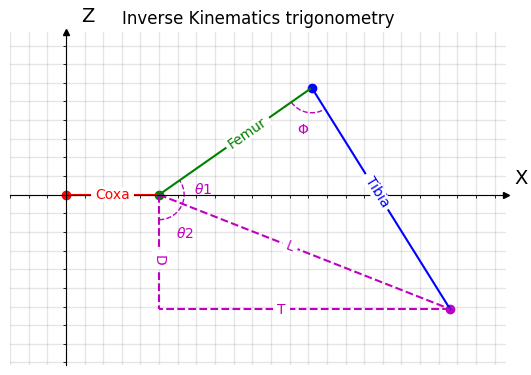

In [11]:
%matplotlib inline

from plotting import plot_ik_lines


coxa_len = 5
femur_len = 10
tibia_len = 14

alpha = 0
beta = 35
gamma = -93

model = forward_kinematics(
    coxa_len,
    femur_len,
    tibia_len,
    alpha,
    beta,
    gamma,
    # Inverse kinematic is defined in terms of leg coordinate frame, so body length and start_z are 0
    start_z=0,
    body_length=0,
)

fig, ax, _, _ = plot_leg_with_points(
    model,
    'Inverse Kinematics trigonometry',
    no_link_labels=True,
    no_joint_labels=True,
    no_cartesian_ticks=True,
)

body, coxa, femur, tibia = model

plot_ik_lines(ax, femur, tibia)


As you can see on the diagram above, there are 2 triangles formed by leg links and additional lines `D`, `T` and `L`. 

Angles $\theta1$, $\theta2$, $\Phi$ are the angles we need to find. They will allow us to compute $\beta$ and $\gamma$.

`D` - is simple, it is the foot's target Z coordinate, negated.

`T` is fairly simple as well, it is target X coordinate minus coxa length.

`L` - is hypotenuse of the triangle formed by `D` and `T` which can be computed using Pythagorean theorem: $L = \sqrt{D^2 + T^2}$ (or `L = math.hypot(D, T)` in python)

Since `L`, `D`, `T` form a square triangle, $\theta2$ can be computed using trigonometry: $\theta2 = \arctan(\frac{T}{D})$ (or `theta2 = math.atan2(T, D)` in python)

---

For $\theta1$ and $\Phi$ we need to use [law of cosines](https://www.geeksforgeeks.org/law-of-cosine/):

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240607181448/Law-of-Cosines-copy.webp" width="500">

Which can be rewritten to compute angles as:

$\Large \cos A = (\frac{b^2 + c^2 – a^2}{2bc})$

$\Large \cos B = (\frac{a^2 + c^2 – b^2}{2ac})$


In our case:

$a = L$

$b = tibia$

$c = femur$

angle $A = \Phi$

angle $B = \theta1$

---


Therefore:

$\Large \theta1 = \arccos(\frac{L^2 + femur^2 - tibia^2}{2 * L * femur})$

or in python `theta1 = math.acos((L**2 + femur**2 - tibia**2) / (2 * L * femur))`

Similarly $\Large \Phi = \arccos(\frac{tibia^2 + femur^2 - L^2}{2 * tibia * femur})$

or in python `phi = math.acos((tibia**2 + femur**2 - L**2) / (2 * tibia * femur))`

What is left is to compute $\beta$ and $\gamma$ using the following formulas: 

$\beta = \theta1 + \theta2 - 90$ (offset by 90 degrees to align with leg coordinate frame, see diagram below of a straight leg)

$\gamma = \Phi - 180$



And that is all, lets put it all together:

theta1=56.45772587043364
theta2=68.52841976460098
phi=87.0052800205357

beta=34.98614563503463
gamma=-92.9947199794643


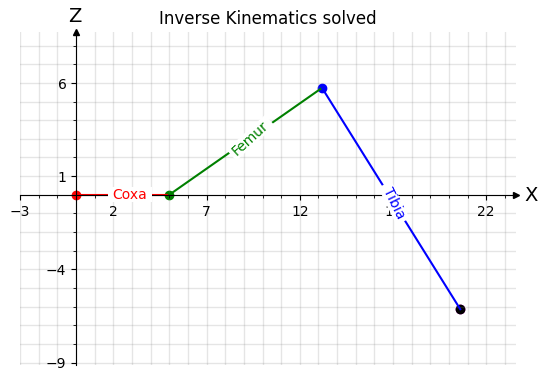

In [12]:
%matplotlib inline

import math


def solve_and_plot_at_target(foot_target: Point, plot_title='Inverse Kinematics solved'):
    def inverse_kinematics(coxa, femur, tibia, foot_target):
        """
        XZ axis Inverse kinematics solver for 3DOF leg.

        Math as described above
        """
        D = -foot_target.y
        T = foot_target.x - coxa
        L = math.hypot(D, T)

        theta1 = math.degrees(math.acos((L**2 + femur**2 - tibia**2) / (2 * L * femur)))
        theta2 = math.degrees(math.atan2(T, D))
        phi = math.degrees(math.acos((tibia**2 + femur**2 - L**2) / (2 * tibia * femur)))

        beta = (theta1 + theta2) - 90
        gamma = phi - 180
        print(f'{theta1=}\n{theta2=}\n{phi=}\n\n{beta=}\n{gamma=}')
        return beta, gamma

    beta, gamma = inverse_kinematics(coxa_len, femur_len, tibia_len, foot_target)

    model = forward_kinematics(
        coxa_len,
        femur_len,
        tibia_len,
        alpha,
        beta,
        gamma,
        # Inverse kinematic is defined in terms of leg coordinate frame, so body length and start_z are 0
        start_z=0,
        body_length=0,
    )

    fig, ax, _, _ = plot_leg_with_points(
        model,
        plot_title,
        no_joint_labels=True,
    )

    ax.scatter(foot_target.x, foot_target.y, color='k', label='Foot target')
    ax.legend().remove()

solve_and_plot_at_target(Point(20.61, -6.14))


theta1=0.0
theta2=90.0
phi=180.0

beta=0.0
gamma=0.0


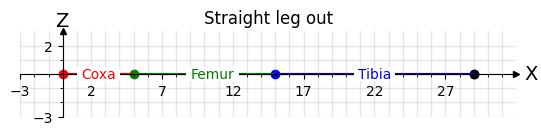

In [13]:
solve_and_plot_at_target(Point(coxa_len + femur_len + tibia_len, 0), "Straight leg out")

# Pay attention to printed out theta and phi, they are exactly equal to the values we use for offset to beta and gamma

theta1=56.45772587043364
theta2=111.47158023539903
phi=87.0052800205357

beta=77.92930610583267
gamma=-92.9947199794643


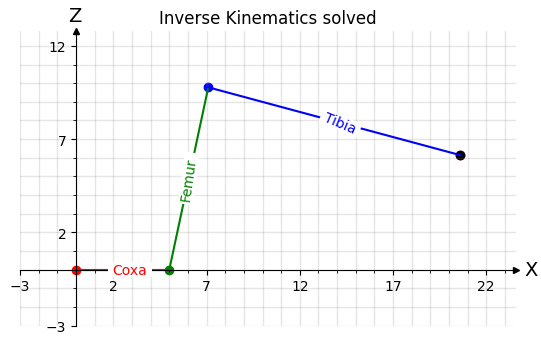

In [14]:
solve_and_plot_at_target(Point(20.61, 6.14))

theta1=88.85400800161142
theta2=90.0
phi=45.5729959991943

beta=88.85400800161142
gamma=-134.4270040008057


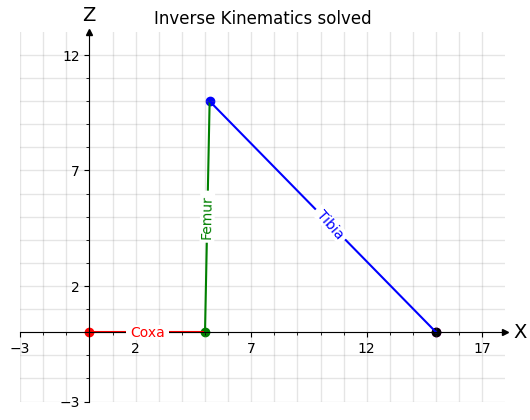

In [15]:
solve_and_plot_at_target(Point(15, 0))

### Coxa Inverse Kinematics

The leg geometry we have seen so far for femur and tibia joints (angles beta and gamma) is a side view of the leg (XZ plane). Coxa joint (alpha) is located in the plane orthogonal to it (XY plane).



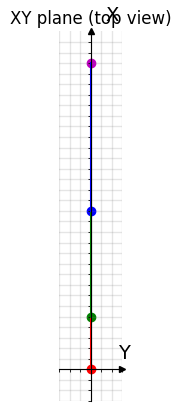

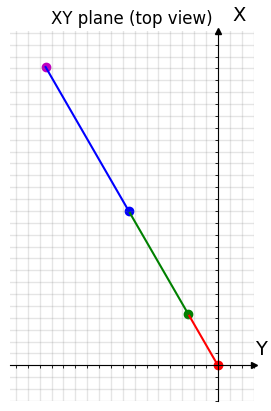

In [16]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection

def forward_kinematics_xy(coxa_length, femur_length, tibia_length, alpha):
    body_rad = np.radians(90)
    alpha_rad = body_rad + np.radians(alpha)
    start = Point(0, 0)
    body = start + Point(0, 0, rf'$\alpha$={alpha}°').rotate(body_rad)
    coxa = body + Point(coxa_length, 0).rotate(alpha_rad)
    femur = coxa + Point(femur_length, 0).rotate(alpha_rad)
    tibia = femur + Point(tibia_length, 0, 'Foot').rotate(alpha_rad)

    return Line(start, body, 'Body'), Line(body, coxa, 'Coxa'), Line(coxa, femur, 'Femur'), Line(femur, tibia, 'Tibia')


def plot_leg_with_points_xy(model: list[Line], title: str):
    # for link in model:
    #     link.start.y, link.start.x = link.start.x, link.start.y
    #     link.end.y, link.end.x = link.end.x, link.end.y

    def rotate_axes(ax: plt.Axes):
        rot = Affine2D().rotate_deg(90)

        for x in ax.images + ax.lines + ax.collections:
            trans = x.get_transform()
            x.set_transform(rot+trans)
            if isinstance(x, PathCollection):
                transoff = x.get_offset_transform()
                x._transOffset = rot+transoff

        old = ax.axis()
        ax.axis(old[2:4] + old[0:2])
    _, ax, _, _ = plot_leg_with_points(model, title, no_link_labels=True, no_joint_labels=True, no_cartesian_ticks=True, x_label='Y', y_label='X')
    ax.legend().remove()


model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, 0)
plot_leg_with_points_xy(model, 'XY plane (top view)')


model = forward_kinematics_xy(coxa_len, femur_len, tibia_len, 30)
plot_leg_with_points_xy(model, 'XY plane (top view)')

theta1=0.0
theta2=90.0
phi=180.0

beta=0.0
gamma=0.0


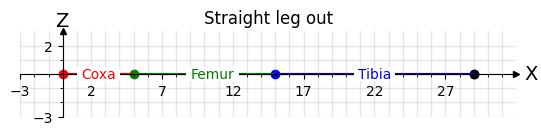

In [17]:
solve_and_plot_at_target(Point(coxa_len + femur_len + tibia_len, 0), "Straight leg out")

# Pay attention to printed out theta and phi, they are exactly equal to the values we use for offset to beta and gamma